In [ ]:
import pandas as pd
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
start = '2020-01-01'
end = '2021-01-01'

In [ ]:
spy = web.get_data_yahoo('SPY', start=start, end=end)

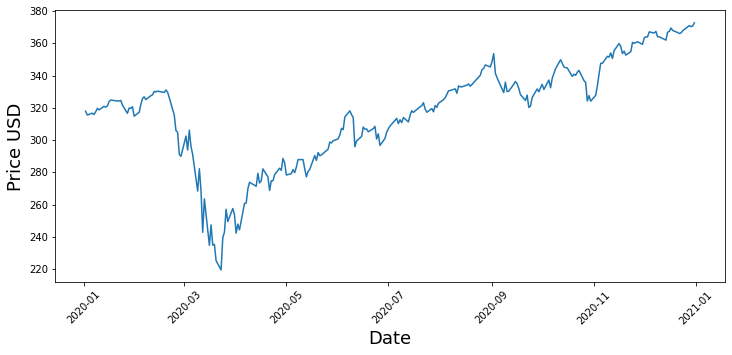

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(spy['Adj Close'], label='Adj Close')
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD', fontsize=18)
plt.show()

In [ ]:
EMA_12 = spy['Adj Close'].ewm(span=12, adjust=False).mean()
EMA_26 = spy['Adj Close'].ewm(span=26, adjust=False).mean()

In [ ]:
MACD = EMA_12 - EMA_26

In [ ]:
signal = MACD.ewm(span=9, adjust=False).mean()

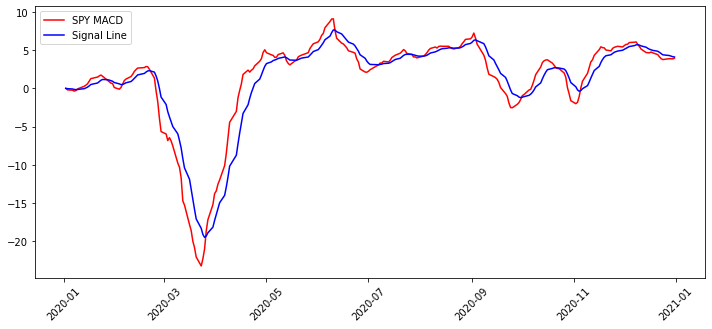

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(spy.index, MACD, label='SPY MACD', color='red')
plt.plot(spy.index, signal, label='Signal Line', color='blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [ ]:
spy['MACD'] = MACD
spy['Signal Line'] = signal

In [ ]:
spy

,High,Low,Open,Close,Volume,Adj Close,MACD,Signal Line
Date,,,,,,,,
2020-01-02,324.890015,322.529999,323.540009,324.869995,59151200.0,317.873199,0.000000,0.000000
2020-01-03,323.640015,321.100006,321.160004,322.410004,77709700.0,315.466217,-0.192010,-0.038402
2020-01-06,323.730011,320.359985,320.489990,323.640015,55653900.0,316.669739,-0.244250,-0.079572
2020-01-07,323.540009,322.239990,323.019989,322.730011,40496400.0,315.779327,-0.353425,-0.134342
2020-01-08,325.779999,322.670013,322.940002,324.450012,68296000.0,317.462311,-0.300678,-0.167609
...,...,...,...,...,...,...,...,...
2020-12-24,369.029999,367.450012,368.079987,369.000000,26457900.0,367.795380,3.761859,4.384778
2020-12-28,372.589996,371.070007,371.739990,372.170013,39000400.0,370.955048,3.876608,4.283144
2020-12-29,374.000000,370.829987,373.809998,371.459991,53680500.0,370.247345,3.865877,4.199691


## Create function
## assume ว่าเราจะซื้อหุ้น ATO วันถัดไปหลังจากจบแท่งเทียน
## แต่ความปวดหัวมันอยู่ที่ ราคา Adj Close ช่างต่างกับ Open ดังนั้นเราต้อง pro-rate กันหน่อย

In [ ]:
test = spy['Adj Close']/spy['Close']
test.describe()

count    253.000000
mean       0.986609
std        0.005393
min        0.978463
25%        0.984216
50%        0.988548
75%        0.992505
max        0.996735
dtype: float64

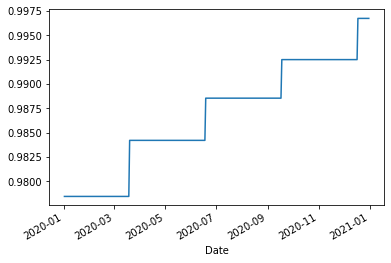

In [ ]:
test.plot()

## มันมีอะไรกันนะ หลักๆก็เป็นการจัดการกับพวกปันผล stock split นั่นเอง

งั้นเราแก้ง่ายๆด้วยการ pro rate วิธีการอาจไม่ถูกนักแต่พอไปวัดไปวา

In [ ]:
spy['Adj Open'] = spy['Adj Close']/spy['Close'] * spy['Open']
spy

,High,Low,Open,Close,Volume,Adj Close,MACD,Signal Line,Adj Open
Date,,,,,,,,,
2020-01-02,324.890015,322.529999,323.540009,324.869995,59151200.0,317.873199,0.000000,0.000000,316.571857
2020-01-03,323.640015,321.100006,321.160004,322.410004,77709700.0,315.466217,-0.192010,-0.038402,314.243138
2020-01-06,323.730011,320.359985,320.489990,323.640015,55653900.0,316.669739,-0.244250,-0.079572,313.587557
2020-01-07,323.540009,322.239990,323.019989,322.730011,40496400.0,315.779327,-0.353425,-0.134342,316.063060
2020-01-08,325.779999,322.670013,322.940002,324.450012,68296000.0,317.462311,-0.300678,-0.167609,315.984822
...,...,...,...,...,...,...,...,...,...
2020-12-24,369.029999,367.450012,368.079987,369.000000,26457900.0,367.795380,3.761859,4.384778,366.878370
2020-12-28,372.589996,371.070007,371.739990,372.170013,39000400.0,370.955048,3.876608,4.283144,370.526428
2020-12-29,374.000000,370.829987,373.809998,371.459991,53680500.0,370.247345,3.865877,4.199691,372.589679


In [ ]:
#create function buy at ATO หลังจบแท่งเทียน
def buy_sell(signal):
    sigPriceBuy = []
    sigPriceSell = []
    flag = -1
    for i in range(0, len(signal)):
        if signal['MACD'][i] > signal['Signal Line'][i]:
            if flag !=1:
                sigPriceBuy.append(signal['Adj Open'][i+1])
                sigPriceSell.append(np.nan)
                flag = 1
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif signal['MACD'][i] < signal['Signal Line'][i]:
            if flag != 0:
                sigPriceSell.append(signal['Adj Open'][i+1])
                sigPriceBuy.append(np.nan)
                flag = 0
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else:
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
            
    return(sigPriceBuy, sigPriceSell)

In [ ]:
x = buy_sell(spy)
spy['Buy_Signal_Price'] = x[0]
spy['Sell_Signal_Price'] = x[1]

In [ ]:
spy.head()
#signal price ต้องตรงกันกับ Adj Open

,High,Low,Open,Close,Volume,Adj Close,MACD,Signal Line,Adj Open,Buy_Signal_Price,Sell_Signal_Price
Date,,,,,,,,,,,
2020-01-02,324.890015,322.529999,323.540009,324.869995,59151200.0,317.873199,0.000000,0.000000,316.571857,NaN,NaN
2020-01-03,323.640015,321.100006,321.160004,322.410004,77709700.0,315.466217,-0.192010,-0.038402,314.243138,NaN,313.587557
2020-01-06,323.730011,320.359985,320.489990,323.640015,55653900.0,316.669739,-0.244250,-0.079572,313.587557,NaN,NaN
2020-01-07,323.540009,322.239990,323.019989,322.730011,40496400.0,315.779327,-0.353425,-0.134342,316.063060,NaN,NaN
2020-01-08,325.779999,322.670013,322.940002,324.450012,68296000.0,317.462311,-0.300678,-0.167609,315.984822,NaN,NaN


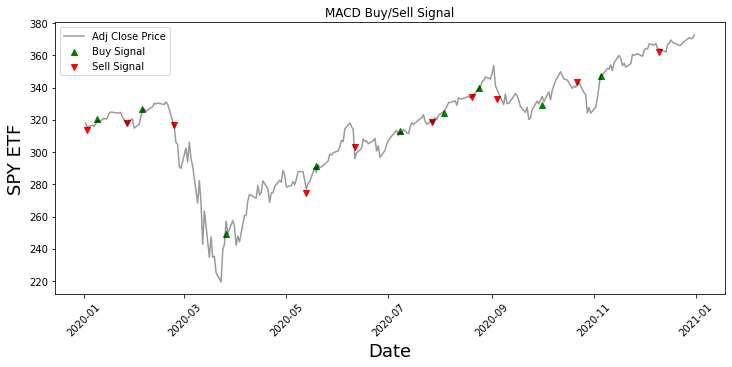

In [ ]:
plt.figure(figsize=(12,5))
plt.scatter(spy.index, spy['Buy_Signal_Price'], color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(spy.index, spy['Sell_Signal_Price'], color='red', label='Sell Signal', marker='v', alpha=1)
plt.plot(spy['Adj Close'], label='Adj Close Price',color='black', alpha=0.4)
plt.xticks(rotation=45)
plt.title('MACD Buy/Sell Signal')
plt.xlabel('Date', fontsize=18)
plt.ylabel('SPY ETF', fontsize=18)
plt.legend(loc='upper left')
plt.show()

In [ ]:
#รวมร่างหน่อยเพื่อความง่าย code ชุดนี้ไม่ได้ cross check ในเน็ต เรามั่วมาเอง มีผิดถูกตรงไหนแจ้งได้ครับ
spy['Action Price']  = spy['Buy_Signal_Price'].fillna(0) + spy['Sell_Signal_Price'].fillna(0)
spy_macd = spy[spy['Action Price'] != 0]
spy_macd

,High,Low,Open,Close,Volume,Adj Close,MACD,Signal Line,Adj Open,Buy_Signal_Price,Sell_Signal_Price,Action Price
Date,,,,,,,,,,,,
2020-01-03,323.640015,321.100006,321.160004,322.410004,77709700.0,315.466217,-0.192010,-0.038402,314.243138,NaN,313.587557,313.587557
2020-01-09,326.730011,325.519989,326.160004,326.649994,48473300.0,319.614868,-0.084211,-0.150930,319.135431,320.241117,NaN,320.241117
2020-01-27,325.119995,322.660004,323.029999,323.500000,84062500.0,316.532745,1.035653,1.135256,316.072867,NaN,318.059128,318.059128
2020-02-05,333.089996,330.670013,332.269989,332.859985,65951100.0,325.691132,0.569270,0.507982,325.113842,326.718518,NaN,326.718518
2020-02-24,333.559998,321.239990,323.140015,322.420013,161088400.0,315.475983,1.351292,2.122391,316.180477,NaN,316.963235,316.963235
2020-03-26,262.799988,249.050003,249.520004,261.200012,257632800.0,257.077362,-18.613842,-19.289303,245.581706,249.272509,NaN,249.272509
2020-05-13,287.190002,278.959991,286.059998,281.600006,144721100.0,277.155365,3.595024,4.003876,281.544962,NaN,274.547226,274.547226
2020-05-19,296.209991,291.950012,294.350006,291.970001,95189300.0,287.361664,3.676689,3.672702,289.704104,291.150942,NaN,291.150942
2020-06-11,312.149994,300.010010,311.459991,300.609985,209243600.0,295.865326,7.546993,7.616402,306.544082,NaN,303.374900,303.374900


In [ ]:
#เราเริ่มต้นที่ซื้อก่อน ค่อยขาย ดังนั้นเราจะ drop สัญญาณขายแรกทิ้ง
spy_macd = spy_macd.iloc[1:,-1]

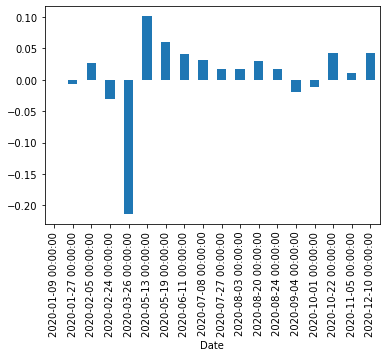

In [ ]:
spy_macd.pct_change().plot.bar()

# อื้ม ไม่เลวๆ แต่จริงๆแล้ว data นี้ bias หนักมากน่ะ
# ถัดไปก็จะเป็นการเรียนรู้ Trial And Error 
## เราจะใช้ตัวอย่างจาก MACD นี่ละ